これによると需要予測ができるぽい

http://www.itmedia.co.jp/business/articles/1702/17/news125.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 日本語表示
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'

# Warningを非表示
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("../data_raw/train.csv")
df_train.tail()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
1716,16233,3756,2014,Ｊ２,第２４節第１日,07/30(水),19:04,カターレ富山,愛媛ＦＣ,富山県総合運動公園陸上競技場,スカパー！／スカパー！プレミアムサービス
1717,16234,7842,2014,Ｊ２,第２４節第１日,07/30(水),19:04,ジュビロ磐田,カマタマーレ讃岐,ヤマハスタジアム（磐田）,スカパー！／スカパー！プレミアムサービス
1718,16235,5212,2014,Ｊ２,第２４節第１日,07/30(水),19:04,ＦＣ岐阜,ファジアーノ岡山,岐阜メモリアルセンター長良川競技場,スカパー！／スカパー！プレミアムサービス
1719,16236,3883,2014,Ｊ２,第２４節第１日,07/30(水),19:03,アビスパ福岡,湘南ベルマーレ,レベルファイブスタジアム,スカパー！／スカパー！プレミアムサービス
1720,16237,5028,2014,Ｊ２,第２４節第１日,07/30(水),19:03,大分トリニータ,栃木ＳＣ,大分銀行ドーム,スカパー！／スカパー！プレミアムサービス


## スタジアム別平均入場者数

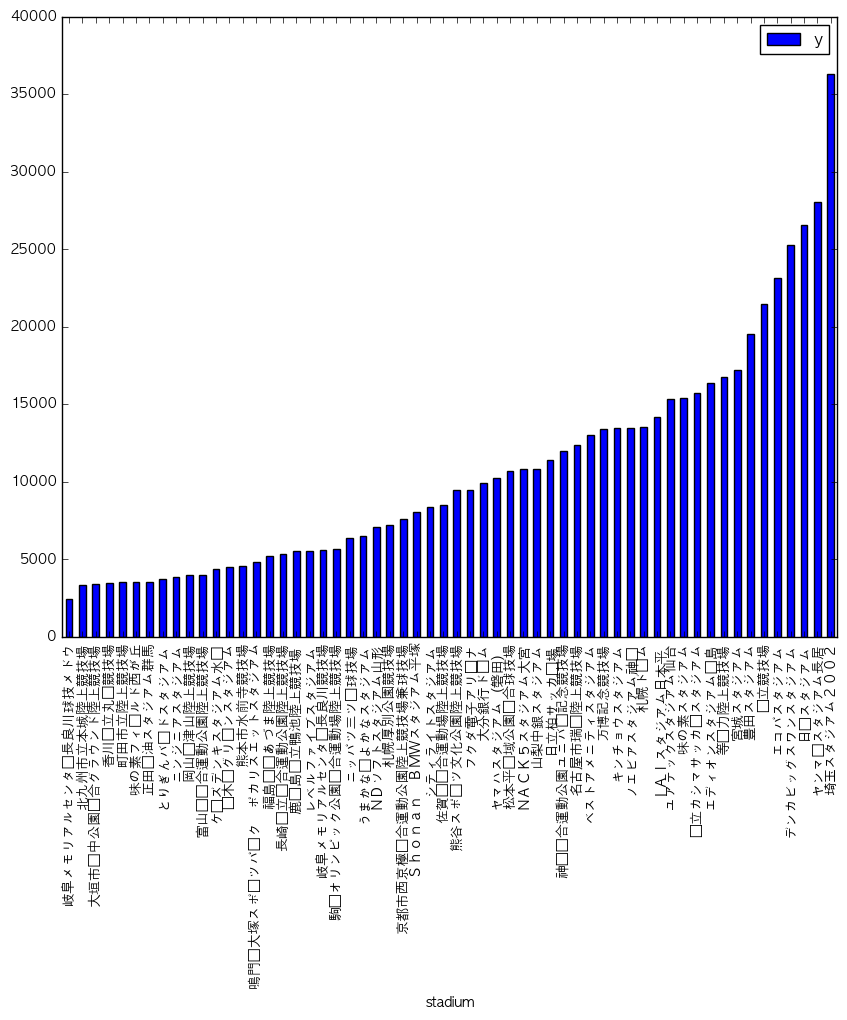

In [3]:
df_train.groupby('stadium')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

In [4]:
avg_cus = []
for stadium, group in df_train.groupby('stadium')['y']:
    avg_cus.append([stadium, np.mean(group)])
df_avg_cus = pd.DataFrame(avg_cus, columns=['stadium', 'avg_cus'])
df_train = pd.merge(df_train, df_avg_cus, on='stadium')

## 曜日

In [5]:
# 曜日だけ取り出す
df_train['youbi'] = df_train['gameday'].apply(lambda g: g.split('(')[1].replace(')', '').replace('祝','').replace('休','').replace('・', ''))

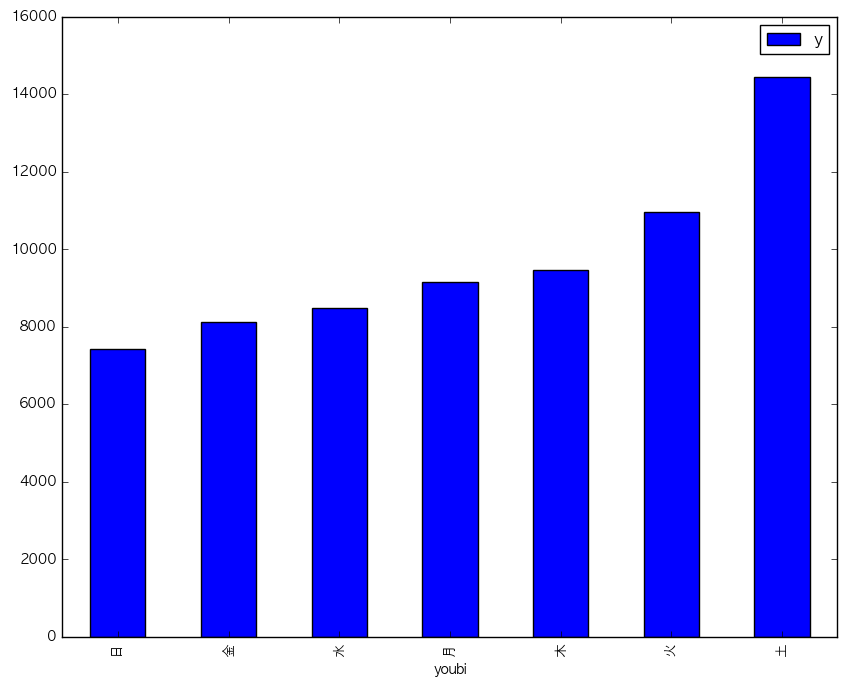

In [6]:
# 曜日別の観客動員数平均
df_train.groupby('youbi')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

## 節

In [7]:
# 節だけ取り出す
df_train['setsu'] = df_train['match'].apply(lambda m: int(m.split('節')[0].replace('第','')))

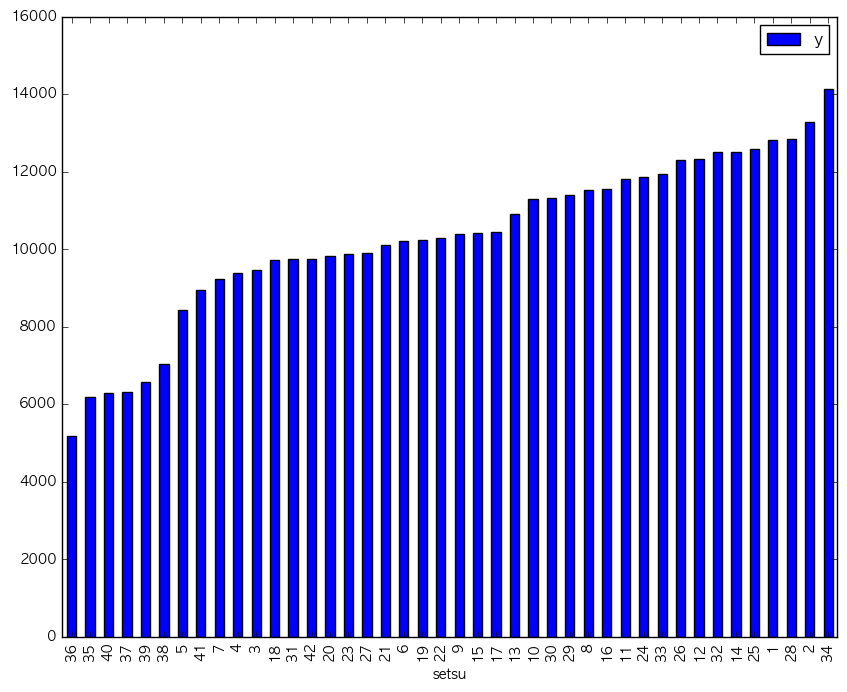

In [8]:
# 節別の観客動員数平均
df_train.groupby('setsu')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

## 開始時間

In [9]:
# 節だけ取り出す
df_train['start_hour'] = df_train['time'].apply(lambda m: int(m.split(':')[0]))

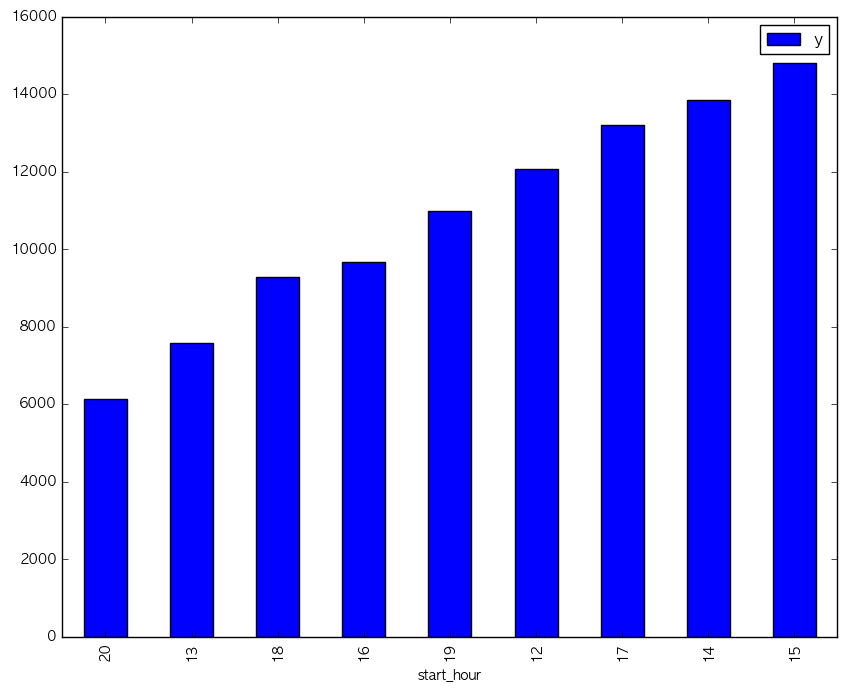

In [10]:
# 開始時間別の観客動員数平均
df_train.groupby('start_hour')['y'].mean().to_frame().sort_values(by='y').plot.bar(figsize=(10, 8))

## カテゴリデータを数値にする

In [11]:
# 曜日
youbi_mapping = { '月': 0, '火': 1, '水': 2, '木': 3, '金': 4, '土': 5, '日': 6 }
df_train['youbi_val'] = df_train['youbi'].map(youbi_mapping).astype(int)

## トレーニングデータを用意する

In [12]:
# 日付順でソートしておく
df_train = df_train.sort(columns=['gameday', 'time'])
x = df_train[['avg_cus', 'start_hour', 'youbi_val', 'setsu']].values
y = df_train['y'].values
x.shape, y.shape

((1721, 4), (1721,))

In [13]:
#  train, cross validation に分ける
from sklearn.model_selection import train_test_split
train_size = 0.8
divided_index = int(len(x) * train_size)
x_train, y_train = x[:divided_index], y[:divided_index]
x_val,    y_val   = x[divided_index:], y[divided_index:]
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((1376, 4), (1376,)), ((345, 4), (345,)))

## 重回帰分析に入れて予測してみる

In [14]:
# 重回帰分析のトレーニングと予測
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred = lr.predict(x_train)

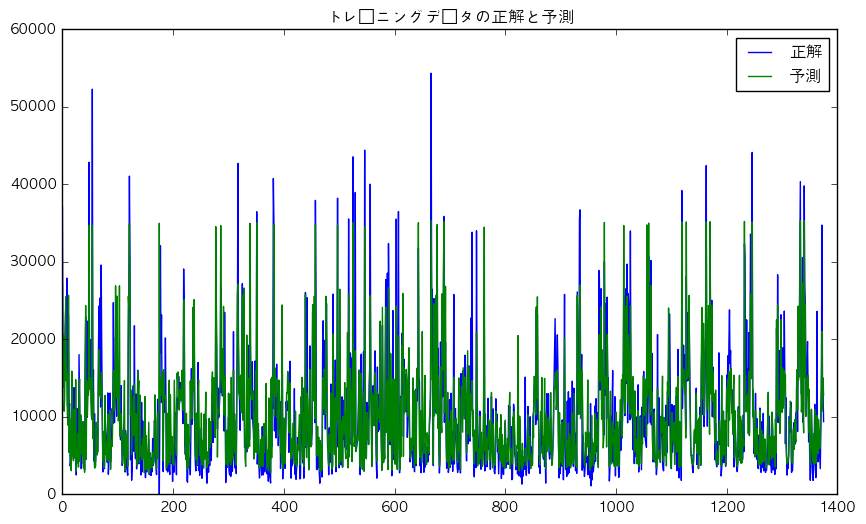

In [15]:
# プロットしてみる
plt.figure(figsize=(10, 6))
xlin = np.arange(0, len(y_train))
plt.title('トレーニングデータの正解と予測')
plt.plot(xlin, y_train, label='正解')
plt.plot(xlin, y_train_pred, label='予測')
plt.legend()
plt.show()

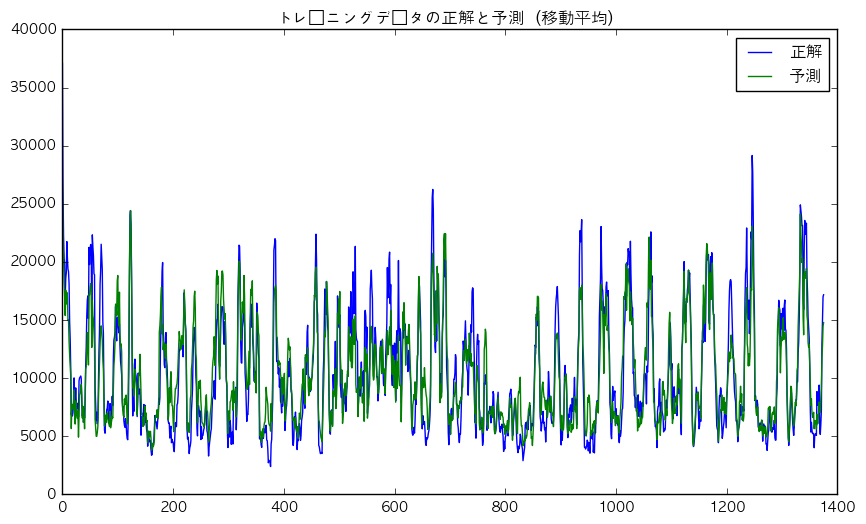

In [16]:
# よくわからないので、5日の移動平均にしてみる
# それなりに予測できている
plt.figure(figsize=(10, 6))
xlin = np.arange(0, len(y_train))
plt.title('トレーニングデータの正解と予測（移動平均）')
plt.plot(xlin, pd.rolling_mean(y_train, 5, 1), label='正解')
plt.plot(xlin, pd.rolling_mean(y_train_pred, 5, 1), label='予測')
plt.legend()
plt.show()

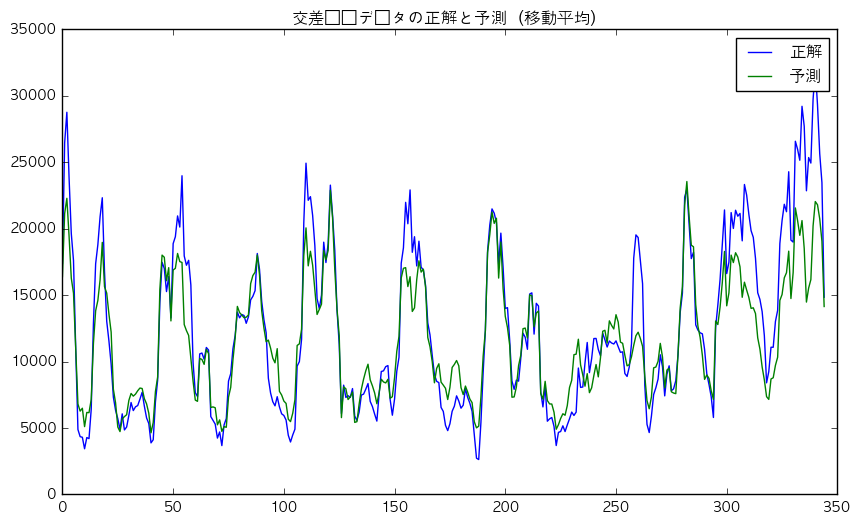

In [17]:
# 検証データの正解と予測（5日の移動平均)
# いい感じで予測できてそう。オーバーフィッティングしてなさそう
y_val_pred = lr.predict(x_val)

plt.figure(figsize=(10, 6))
xlin = np.arange(0, len(y_val))
plt.title('交差検証データの正解と予測（移動平均）')
plt.plot(xlin, pd.rolling_mean(y_val, 5, 1), label='正解')
plt.plot(xlin, pd.rolling_mean(y_val_pred, 5, 1), label='予測')
plt.legend()
plt.show()

## 説明変数の確認

参考: http://pythondatascience.plavox.info/scikit-learn/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0

In [18]:
# 説明変数の係数の表示
for label, val in zip(['スタジアムあたりの平均観客数', '開始時間', '曜日', '節'], lr.coef_):
    print('偏回帰係数%s: %f' % (label, val))
print('切片:', lr.intercept_)

偏回帰係数スタジアムあたりの平均観客数: 0.965228
偏回帰係数開始時間: -95.419185
偏回帰係数曜日: 72.264084
偏回帰係数節: 35.105824
切片: 797.28167388


上記の値から下記の式で観客動員数を予測できる
例）曜日は土日のほうがよく、開始時間が速いほどよいなど

$
観客動員数 = スタジアムの平均観客動員数 * 0.96 + 開始時刻 * -95 + 曜日 * 72 + 節 * 35 + 792
$